# Phase 2: Build Final Six Machine Learning Models (Including Random Forest and XGBoost Model from Phase 1) and Evaluate AUC on the Validation Dataset

In [102]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV as gs
from sklearn.neural_network import MLPClassifier
import optuna 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy

train = pd.read_csv('insurance_t.csv')
valid = pd.read_csv('insurance_v.csv')
train

,ACCTAGE,DDA,DDABAL,DEP,DEPAMT,CHECKS,DIRDEP,NSF,NSFAMT,PHONE,...,CCPURC,SDB,INCOME,LORES,HMVAL,AGE,CRSCORE,INAREA,INS,BRANCH
0,0.7,1,1986.81,1,446.93,1,1,0,0.00,0.0,...,1.0,0,4.0,7.0,87.0,51.0,674.0,1,0,B2
1,4.1,0,0.00,0,0.00,0,0,0,0.00,0.0,...,0.0,0,30.0,8.5,97.0,60.0,640.0,1,1,B3
2,12.3,1,1069.78,5,6813.58,13,1,0,0.00,2.0,...,0.0,0,19.0,3.0,107.0,55.0,662.0,1,1,B7
3,0.8,1,190.03,3,880.25,1,0,1,5.65,NaN,...,NaN,1,20.0,4.0,107.0,40.0,642.0,1,0,B14
4,1.6,1,257.13,5,3408.35,14,0,1,60.25,NaN,...,NaN,0,24.0,8.5,95.0,54.0,732.0,1,0,B15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8490,10.8,1,2262.87,2,4761.00,7,0,1,7.75,2.0,...,1.0,0,60.0,4.5,111.0,38.0,655.0,1,0,B2
8491,6.5,1,3683.22,2,3271.05,13,1,0,0.00,0.0,...,0.0,0,NaN,NaN,NaN,NaN,668.0,1,0,B2
8492,8.6,1,46593.63,3,55203.58,9,1,0,0.00,0.0,...,0.0,0,45.0,8.5,207.0,70.0,721.0,1,0,B3
8493,NaN,0,0.00,0,0.00,0,0,0,0.00,0.0,...,0.0,0,69.0,6.5,124.0,37.0,586.0,1,1,B1


## Data processing

# Impute missing values on train

In [103]:
import pandas as pd

unique_counts = train.nunique()

# Filter columns with fewer than 10 unique values
binary = unique_counts[unique_counts == 2].index.tolist()
categorical = unique_counts[(unique_counts > 2) & (unique_counts < 10)].index.tolist()
continuous = unique_counts[unique_counts >= 10].index.tolist()

# Display the result
print("Binary:", binary)
print("Categorical:", categorical)
print("Continuous:", continuous)

# Finalize the category
binary = ['DDA', 'DIRDEP', 'NSF', 'SAV', 'ATM', 'CD', 'IRA', 'INV', 'MM', 'CC', 'SDB', 'INAREA', 'INS']
categorical = ['MMCRED', 'CCPURC', 'BRANCH']
continuous = ['ACCTAGE', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'NSFAMT', 'PHONE', 'TELLER', 'SAVBAL', 'ATMAMT', 'POS', 'POSAMT', 'CDBAL', 'IRABAL', 'INVBAL', 'MMBAL', 'CCBAL', 'INCOME', 'LORES', 'HMVAL', 'AGE', 'CRSCORE']

# Check for missing values in binary variables
print(train[binary].isna().sum())

# Replace missing values with "M"
train[binary] = train[binary].apply(lambda x: x.fillna("M"))

# Check for missing values again
print(train[binary].isna().sum())

# Check for missing values in categorical variables
print(train[categorical].isna().sum())

# Replace missing values with "M"
train[categorical] = train[categorical].apply(lambda x: x.fillna("M"))

# Check for missing values again
print(train[categorical].isna().sum())

# Check for missing values in continuous variables
print(train[continuous].isna().sum())

# Loop through each continuous variable to add flag columns and impute missing values
for col_name in continuous:
    # Create a flag column to indicate NA values
    flag_column = f"{col_name}_is_imputed"
    train[flag_column] = train[col_name].isna()
    
    # Calculate the median value and replace NA with the median
    median_value = train[col_name].median(skipna=True)
    train[col_name].fillna(median_value, inplace=True)

# Check for missing values again
print(train[continuous].isna().sum())


Binary: ['DDA', 'DIRDEP', 'NSF', 'SAV', 'ATM', 'CD', 'IRA', 'INV', 'MM', 'CC', 'SDB', 'INAREA', 'INS']
Categorical: ['MMCRED', 'CCPURC']
Continuous: ['ACCTAGE', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'NSFAMT', 'PHONE', 'TELLER', 'SAVBAL', 'ATMAMT', 'POS', 'POSAMT', 'CDBAL', 'IRABAL', 'INVBAL', 'MMBAL', 'CCBAL', 'INCOME', 'LORES', 'HMVAL', 'AGE', 'CRSCORE', 'BRANCH']
DDA          0
DIRDEP       0
NSF          0
SAV          0
ATM          0
CD           0
IRA          0
INV       1075
MM           0
CC        1075
SDB          0
INAREA       0
INS          0
dtype: int64
DDA       0
DIRDEP    0
NSF       0
SAV       0
ATM       0
CD        0
IRA       0
INV       0
MM        0
CC        0
SDB       0
INAREA    0
INS       0
dtype: int64
MMCRED       0
CCPURC    1075
BRANCH       0
dtype: int64
MMCRED    0
CCPURC    0
BRANCH    0
dtype: int64
ACCTAGE     546
DDABAL        0
DEP           0
DEPAMT        0
CHECKS        0
NSFAMT        0
PHONE      1075
TELLER        0
SAVBAL        0
ATMAM

# Impute mising values on valid

In [104]:
import pandas as pd

unique_counts = valid.nunique()

# Filter columns with fewer than 10 unique values
binary = unique_counts[unique_counts == 2].index.tolist()
categorical = unique_counts[(unique_counts > 2) & (unique_counts < 10)].index.tolist()
continuous = unique_counts[unique_counts >= 10].index.tolist()

# Display the result
print("Binary:", binary)
print("Categorical:", categorical)
print("Continuous:", continuous)

# Finalize the category
binary = ['DDA', 'DIRDEP', 'NSF', 'SAV', 'ATM', 'CD', 'IRA', 'INV', 'MM', 'CC', 'SDB', 'INAREA', 'INS']
categorical = ['MMCRED', 'CCPURC', 'BRANCH']
continuous = ['ACCTAGE', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'NSFAMT', 'PHONE', 'TELLER', 'SAVBAL', 'ATMAMT', 'POS', 'POSAMT', 'CDBAL', 'IRABAL', 'INVBAL', 'MMBAL', 'CCBAL', 'INCOME', 'LORES', 'HMVAL', 'AGE', 'CRSCORE']

# Check for missing values in binary variables
print(valid[binary].isna().sum())

# Replace missing values with "M"
valid[binary] = valid[binary].apply(lambda x: x.fillna("M"))

# Check for missing values again
print(valid[binary].isna().sum())

# Check for missing values in categorical variables
print(valid[categorical].isna().sum())

# Replace missing values with "M"
valid[categorical] = valid[categorical].apply(lambda x: x.fillna("M"))

# Check for missing values again
print(valid[categorical].isna().sum())

# Check for missing values in continuous variables
print(valid[continuous].isna().sum())

# Loop through each continuous variable to add flag columns and impute missing values
for col_name in continuous:
    # Create a flag column to indicate NA values
    flag_column = f"{col_name}_is_imputed"
    valid[flag_column] = valid[col_name].isna()
    
    # Calculate the median value and replace NA with the median
    median_value = valid[col_name].median(skipna=True)
    valid[col_name].fillna(median_value, inplace=True)

# Check for missing values again
print(valid[continuous].isna().sum())


Binary: ['DDA', 'DIRDEP', 'NSF', 'SAV', 'ATM', 'CD', 'IRA', 'INV', 'MM', 'CC', 'SDB', 'INAREA', 'INS']
Categorical: ['PHONE', 'MMCRED', 'CCPURC']
Continuous: ['ACCTAGE', 'DDABAL', 'DEP', 'DEPAMT', 'CHECKS', 'NSFAMT', 'TELLER', 'SAVBAL', 'ATMAMT', 'POS', 'POSAMT', 'CDBAL', 'IRABAL', 'INVBAL', 'MMBAL', 'CCBAL', 'INCOME', 'LORES', 'HMVAL', 'AGE', 'CRSCORE', 'BRANCH']
DDA         0
DIRDEP      0
NSF         0
SAV         0
ATM         0
CD          0
IRA         0
INV       258
MM          0
CC        258
SDB         0
INAREA      0
INS         0
dtype: int64
DDA       0
DIRDEP    0
NSF       0
SAV       0
ATM       0
CD        0
IRA       0
INV       0
MM        0
CC        0
SDB       0
INAREA    0
INS       0
dtype: int64
MMCRED      0
CCPURC    258
BRANCH      0
dtype: int64
MMCRED    0
CCPURC    0
BRANCH    0
dtype: int64
ACCTAGE    132
DDABAL       0
DEP          0
DEPAMT       0
CHECKS       0
NSFAMT       0
PHONE      258
TELLER       0
SAVBAL       0
ATMAMT       0
POS        258


# Handle Quasi Separation Problem

In [105]:
#check quasi


# Loop through each column in binary_variables
for col in binary:
    # Create a contingency table
    contingency_table = pd.crosstab(train[col], train['INS'])
    
    # Check if there are any zero values in the contingency table
    if (contingency_table == 0).any().any():
        print(f"\nContingency table for column: {col} contains zero values")
        print(contingency_table)



Contingency table for column: INS contains zero values
INS     0     1
INS            
0    5577     0
1       0  2918


In [106]:
#check quasi


# Loop through each column in categorical variables
for col in categorical:
    # Create a contingency table
    contingency_table = pd.crosstab(train[col], train['INS'])
    
    # Check if there are any zero values in the contingency table
    if (contingency_table == 0).any().any():
        print(f"\nContingency table for column: {col} contains zero values")
        print(contingency_table)



Contingency table for column: MMCRED contains zero values
INS        0     1
MMCRED            
0       5409  2713
1        130   153
2         33    47
3          4     5
5          1     0


In [108]:
# Convert the MMCRED column to numeric values
train['MMCRED_numeric'] = pd.to_numeric(train['MMCRED'], errors='coerce')

# Convert MMCRED to strings for modification
train['MMCRED_c'] = train['MMCRED'].astype(str)

# Update values based on the numeric conversion
train.loc[train['MMCRED_numeric'] > 2, 'MMCRED_c'] = "3+"

# Convert the updated character column back to category if needed
train['MMCRED_c'] = train['MMCRED_c'].astype('category')

# Print contingency table
print(pd.crosstab(train['MMCRED_c'], train['INS']))

# Rename MMCRED_c back to MMCRED
train['MMCRED'] = train['MMCRED_c']

# Remove MMCRED_c and MMCRED_numeric columns
train.drop(['MMCRED_c', 'MMCRED_numeric'], axis=1, inplace=True)


INS          0     1
MMCRED_c            
0         5409  2713
1          130   153
2           33    47
3+           5     5


In [109]:
# Convert the MMCRED column to numeric values
valid['MMCRED_numeric'] = pd.to_numeric(valid['MMCRED'], errors='coerce')

# Convert MMCRED to strings for modification
valid['MMCRED_c'] = valid['MMCRED'].astype(str)

# Update values based on the numeric conversion
valid.loc[valid['MMCRED_numeric'] > 2, 'MMCRED_c'] = "3+"

# Convert the updated character column back to category if needed
valid['MMCRED_c'] = valid['MMCRED_c'].astype('category')

# Print contingency table
print(pd.crosstab(valid['MMCRED_c'], valid['INS']))

# Rename MMCRED_c back to MMCRED
valid['MMCRED'] = valid['MMCRED_c']

# Remove MMCRED_c and MMCRED_numeric columns
valid.drop(['MMCRED_c', 'MMCRED_numeric'], axis=1, inplace=True)


INS          0    1
MMCRED_c           
0         1334  690
1           37   41
2            9   11
3+           2    0


# Dummy code for all the categorical variables

In [110]:

# One-hot encode the columns listed in 'categorical' in the train and validation set
# drop_first=True removes the first category to prevent the dummy variable trap
traindummies = pd.get_dummies(train[categorical], drop_first=True)
validdummies = pd.get_dummies(valid[categorical], drop_first=True)

# Drop the original categorical variables from the train/validation set
train = train.drop(columns = categorical)
valid = valid.drop(columns=categorical)

# Concatenate the one-hot encoded variables with the remaining columns in the train/ validation set
train = pd.concat([train, traindummies], axis=1)

valid = pd.concat([valid, validdummies], axis=1)

# Display the result
print(train.head())


   ACCTAGE  DDA   DDABAL  DEP   DEPAMT  CHECKS  DIRDEP  NSF  NSFAMT  PHONE  \
0      0.7    1  1986.81    1   446.93       1       1    0    0.00    0.0   
1      4.1    0     0.00    0     0.00       0       0    0    0.00    0.0   
2     12.3    1  1069.78    5  6813.58      13       1    0    0.00    2.0   
3      0.8    1   190.03    3   880.25       1       0    1    5.65    0.0   
4      1.6    1   257.13    5  3408.35      14       0    1   60.25    0.0   

   ...  BRANCH_B18  BRANCH_B19  BRANCH_B2  BRANCH_B3  BRANCH_B4  BRANCH_B5  \
0  ...       False       False       True      False      False      False   
1  ...       False       False      False       True      False      False   
2  ...       False       False      False      False      False      False   
3  ...       False       False      False      False      False      False   
4  ...       False       False      False      False      False      False   

   BRANCH_B6  BRANCH_B7  BRANCH_B8  BRANCH_B9  
0      False  

In [111]:
# One-hot encode the columns listed in 'binary' in the train and validation set
# drop_first=True removes the first category to prevent the dummy variable trap
traindummies = pd.get_dummies(train[binary], drop_first=True)
validdummies = pd.get_dummies(valid[binary], drop_first=True)

# Drop the original binary variables from the train/validation set
train = train.drop(columns=binary)
valid = valid.drop(columns=binary)

# Concatenate the one-hot encoded variables with the remaining columns in the train/validation set
train = pd.concat([train, traindummies], axis=1)
valid = pd.concat([valid, validdummies], axis=1)

# Display the result
print(train.head())
print(valid.head())


   ACCTAGE   DDABAL  DEP   DEPAMT  CHECKS  NSFAMT  PHONE  TELLER  SAVBAL  \
0      0.7  1986.81    1   446.93       1    0.00    0.0       0    0.00   
1      4.1     0.00    0     0.00       0    0.00    0.0       0    0.00   
2     12.3  1069.78    5  6813.58      13    0.00    2.0       9    0.00   
3      0.8   190.03    3   880.25       1    5.65    0.0       0   11.47   
4      1.6   257.13    5  3408.35      14   60.25    0.0       1    9.80   

    ATMAMT  ...  CD  IRA  MM  SDB  INAREA  INS  INV_1.0  INV_M  CC_1.0   CC_M  
0   268.88  ...   0    0   0    0       1    0    False  False    True  False  
1     0.00  ...   0    0   0    0       1    1    False  False    True  False  
2     0.00  ...   0    0   0    0       1    1    False  False    True  False  
3  1582.34  ...   0    0   0    1       1    0    False   True   False   True  
4  3807.19  ...   1    0   0    0       1    0    False   True   False   True  

[5 rows x 85 columns]
   ACCTAGE   DDABAL  DEP   DEPAMT  CHECK

In [112]:
# Split training and validation into 2 objects each: one with target and the other with predictors
y_train = train[['INS']]
y_valid = valid[['INS']]
x_train = train.drop(columns = ['INS'])
x_valid = valid.drop(columns = ['INS'])



In [113]:
x_train = x_train.apply(pd.to_numeric, errors='coerce')


In [114]:
print(x_train.isna().any().any()) 


False


# First model : Naive Bayes model without scaling

In [117]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report


gnb = GaussianNB()
gnb.fit(x_train, y_train)


GaussianNB()

In [118]:
# Predict the class labels for the test set
y_pred = gnb.predict(x_valid)

# Accuracy score
print("Accuracy:", accuracy_score(y_valid, y_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_valid, y_pred))




Accuracy: 0.678436911487759
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.79      1382
           1       0.63      0.20      0.30       742

    accuracy                           0.68      2124
   macro avg       0.66      0.57      0.55      2124
weighted avg       0.66      0.68      0.62      2124



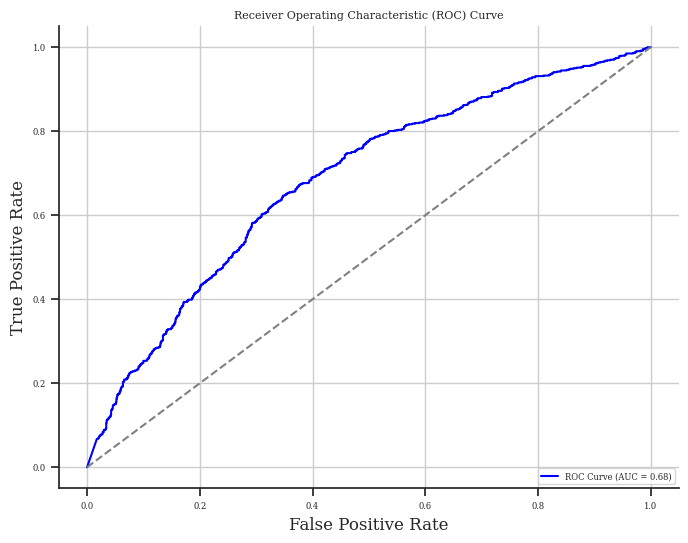

In [119]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_proba = gnb.predict_proba(x_valid)[:, 1]  # Probability of the positive class
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# Second model : Naive Bayes model with scaling

### Scale continuous variables

#### Evaluate distributions of continuous variables

Accuracy: 0.6751412429378532
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      1382
           1       0.55      0.37      0.45       742

    accuracy                           0.68      2124
   macro avg       0.63      0.61      0.61      2124
weighted avg       0.66      0.68      0.66      2124



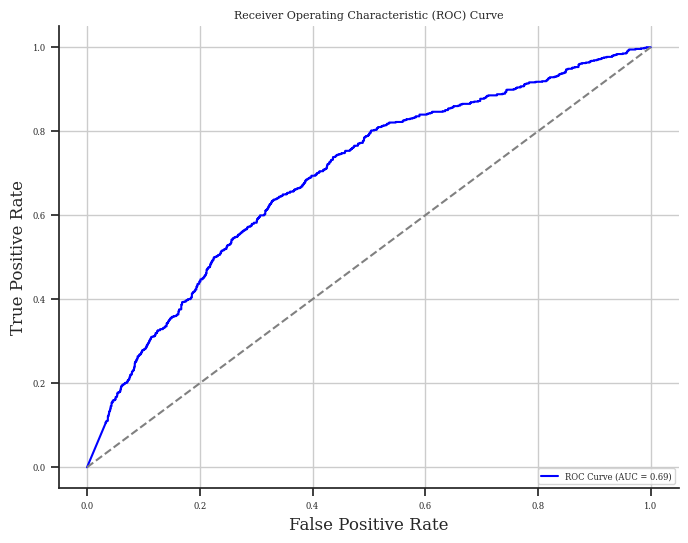

In [121]:
#rebuild with scaled x
from sklearn.preprocessing import StandardScaler  

scaler = StandardScaler()  
scaler.fit(X = x_train)  
x_train_s = scaler.transform(x_train) 
x_valid_s = scaler.transform(x_valid)

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report


gnb = GaussianNB()
gnb.fit(x_train_s, y_train)

# Predict the class labels for the test set
y_pred = gnb.predict(x_valid_s)

# Accuracy score
print("Accuracy:", accuracy_score(y_valid, y_pred))

# Classification report
print("Classification Report:")
print(classification_report(y_valid, y_pred))



from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the test set
y_proba = gnb.predict_proba(x_valid_s)[:, 1]  # Probability of the positive class
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()



# Third Model : neural net model

In [122]:
net_bank = MLPClassifier(solver= 'lbfgs',
                         alpha= 1e-5,
                         hidden_layer_sizes= (5,),
                         random_state= 15)

net_bank.fit(x_train_s, y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5,), random_state=15,
              solver='lbfgs')

### Tune neural net model

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
    'alpha': [0.00005, 0.0001, 0.0003, 0.0005, 0.001],
    'solver': ['lbfgs']
}

nn = MLPClassifier(max_iter = 10000, random_state = 15)

grid_search = GridSearchCV(estimator = nn, param_grid = param_grid, cv = 10, n_jobs=-1)

grid_search.fit(x_train_s, y_train)

In [124]:
# Display the best parameters
print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'alpha': 0.0003, 'hidden_layer_sizes': 5, 'solver': 'lbfgs'}


In [125]:
# Display the best cross-validation score
print("Best Cross-Validation Score:", grid_search.best_score_)


Best Cross-Validation Score: 0.737961615741703


### Best Parameters: {'alpha': 0.0003, 'hidden_layer_sizes': 5, 'solver': 'lbfgs'}

In [126]:
net_bank = MLPClassifier(solver= 'lbfgs',
                         alpha= 0.0003,
                         hidden_layer_sizes= (5,),
                         random_state= 15)

net_bank.fit(x_train_s, y_train)

MLPClassifier(alpha=0.0003, hidden_layer_sizes=(5,), random_state=15,
              solver='lbfgs')

Test Set Accuracy: 0.7391713747645952
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      1382
           1       0.64      0.57      0.60       742

    accuracy                           0.74      2124
   macro avg       0.71      0.70      0.71      2124
weighted avg       0.73      0.74      0.74      2124



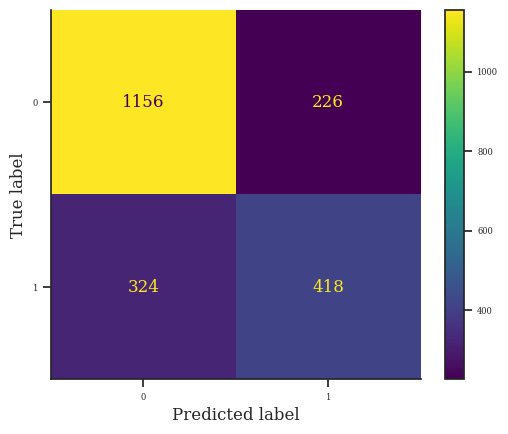

In [128]:
# Scale the validation dataset using the same scaler
x_valid_s = scaler.transform(x_valid)


# Predict using the best model
y_pred = net_bank.predict(x_valid_s)

from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

# Evaluate performance
accuracy = accuracy_score(y_valid, y_pred)
print("Test Set Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(y_valid, y_pred))

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, x_valid_s, y_valid)



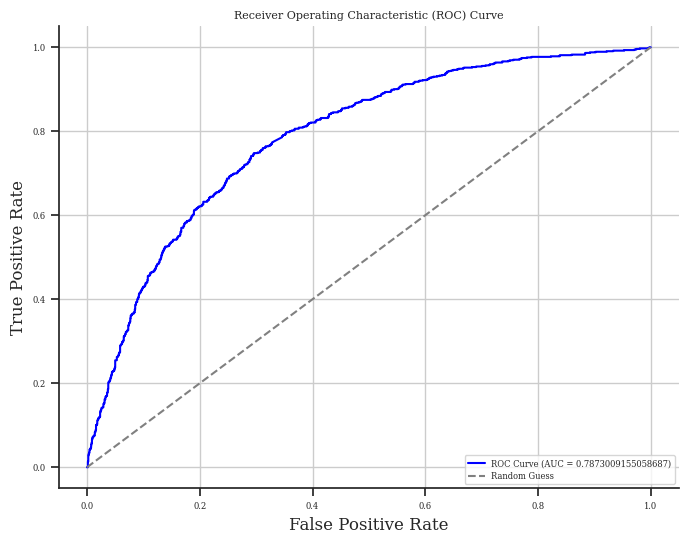

In [130]:
# Get predicted probabilities for the positive class
y_proba = net_bank.predict_proba(x_valid_s)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_valid, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


# Fourth Model : Random Forest model (Hyperparameters were tuned in phase 1)

Area Under the ROC Curve (AUC): 0.7936459718912003


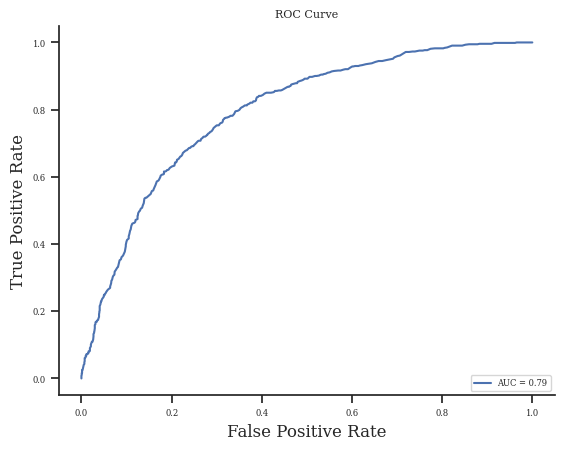

In [131]:
#RF model

#Report the area under the ROC curve as well as a plot of the ROC curve.
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

rf = RandomForestClassifier(n_estimators = 500,
                                max_features = 7,
                                  random_state = 12345,
                                  oob_score = True)

rf.fit(x_train_s, y_train)


# Predict probabilities for the positive class (usually class 1)
y_prob = rf.predict_proba(x_valid_s)[:, 1]

# Calculate the AUC score
auc_score = roc_auc_score(y_valid, y_prob)
print("Area Under the ROC Curve (AUC):", auc_score)

# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Sixth model : XGBoost Model (Hyperparameters were tuned in phase 1)

In [138]:
# Build XG Boost with same parameters as previous 

xgb_insRand = XGBClassifier(n_estimators = 42,
                   subsample = 0.8,
                   eta = 0.16,
                   max_depth = 4,
                   random_state = 15, enable_categorical= True, tree_method= 'hist')

# Generate fitted values
xgb_insRand.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eta=0.16, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=42,
              n_jobs=None, num_parallel_tree=None, ...)

Area Under the ROC Curve (AUC): 0.7974155585287933


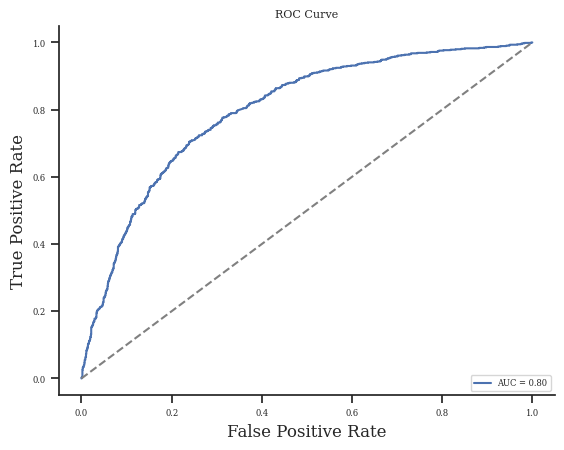

In [139]:
#AUC
# Predict the probabilities for the positive class (usually class 1)
y_prob = xgb_insRand.predict_proba(x_valid)[:, 1]

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(y_valid, y_prob)

# Calculate the AUC score
auc_score = roc_auc_score(y_valid, y_prob)
print("Area Under the ROC Curve (AUC):", auc_score)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for reference
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [150]:
# Calculate KS statistic
ks_stat = max(tpr - fpr)
print("KS Statistic:", ks_stat)


KS Statistic: 0.46534379254254743


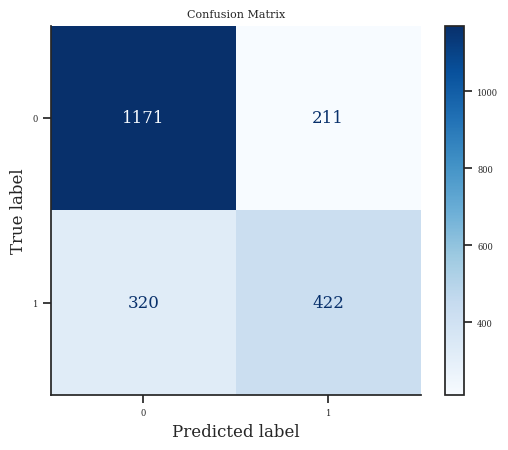

In [141]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels for the validation set
y_pred = xgb_insRand.predict(x_valid)

# Generate the confusion matrix
cm = confusion_matrix(y_valid, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_insRand.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# So, we chose XGBoost model as a final model with a parameter that was chosen in Phase 1, but without dropping variables (we don't need parsimonious model)

In [ ]:
!pip install scikit-explain



In [ ]:
import skexplain
# Build XG Boost with same parameters as previous 

xgb_insRand = XGBClassifier(n_estimators = 42,
                   subsample = 0.8,
                   eta = 0.16,
                   max_depth = 4,
                   random_state = 15, enable_categorical= True, tree_method= 'hist')

# Generate fitted values
xgb_insRand.fit(x_train, y_train)

In [ ]:
import skexplain
from sklearn.metrics import roc_auc_score

# Create an ExplainToolkit instance with XGBClassifier
explainer = skexplain.ExplainToolkit(
    ('XGBoost', xgb_insRand),  # Replace 'Random Forest' with your XGBClassifier
    X=x_train,
    y=y_train
)

# Perform permutation importance with classification metrics
results = explainer.permutation_importance(
    n_vars=14,
    evaluation_fn='auc',  # Use 'auc' or 'accuracy' for classification
    n_permute=5,
    random_seed=12345
)

# Display the results
print("Permutation Importance Results:")
print(results)


Perm. Imp.: 100%|██████████| 14/14 [01:42<00:00,  7.29s/it]

Permutation Importance Results:
<xarray.Dataset>
Dimensions:                                (n_vars_multipass: 14, n_permute: 5,
                                            n_vars_singlepass: 84)
Dimensions without coordinates: n_vars_multipass, n_permute, n_vars_singlepass
Data variables:
    backward_multipass_rankings__XGBoost   (n_vars_multipass) <U16 'SAVBAL' ....
    backward_multipass_scores__XGBoost     (n_vars_multipass, n_permute) float64 ...
    backward_singlepass_rankings__XGBoost  (n_vars_singlepass) <U18 'SAVBAL' ...
    backward_singlepass_scores__XGBoost    (n_vars_singlepass, n_permute) float64 ...
    original_score__XGBoost                (n_permute) float64 0.8495 ... 0.8495
Attributes:
    estimator_output:  probability
    estimators used:   ['XGBoost']
    n_multipass_vars:  14
    method:            permutation_importance
    direction:         backward
    evaluation_fn:     auc


In [157]:
variables = results["backward_multipass_rankings__XGBoost"].values
scores = results["backward_multipass_scores__XGBoost"].mean(dim="n_permute").values  # Average over permutations

# Create a DataFrame for easier manipulation
importance_df = pd.DataFrame({
    "Variable": variables,
    "Importance": scores
})

# Rank-order by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Display the top variables
print(importance_df)

# Optionally save to a CSV file
# importance_df.to_csv("permutation_importance_results.csv", index=False)


            Variable  Importance
0             SAVBAL    0.732619
1             DDABAL    0.664672
2              CDBAL    0.624062
3                DDA    0.594096
4              MMBAL    0.569093
5             ATMAMT    0.564235
6             CC_1.0    0.563061
7             CHECKS    0.553185
8                IRA    0.544209
9            INV_1.0    0.526709
10               DEP    0.526388
11            IRABAL    0.525488
12  PHONE_is_imputed    0.522542
13            TELLER    0.517008


In [160]:
variables = results["backward_singlepass_rankings__XGBoost"].values
scores = results["backward_singlepass_scores__XGBoost"].mean(dim="n_permute").values  # Average over permutations

# Create a DataFrame for easier manipulation
importance_df = pd.DataFrame({
    "Variable": variables,
    "Importance": scores
})

# Rank-order by importance
importance_df = importance_df.sort_values(by="Importance", ascending=False).reset_index(drop=True)

# Display the top variables
print(importance_df)

# Optionally save to a CSV file
# importance_df.to_csv("permutation_importance_results.csv", index=False)

             Variable  Importance
0                CC_M    0.849531
1    HMVAL_is_imputed    0.849531
2   INCOME_is_imputed    0.849531
3    CCBAL_is_imputed    0.849531
4    MMBAL_is_imputed    0.849531
..                ...         ...
79              MMBAL    0.831501
80              CDBAL    0.821803
81                DDA    0.820543
82             DDABAL    0.790744
83             SAVBAL    0.732619

[84 rows x 2 columns]


In [144]:
imp_vars = ['ACCTAGE']

ale = explainer.ale(features = imp_vars)

ALE Numerical Features: 100%|██████████| 1/1 [00:00<00:00, 13.34it/s]


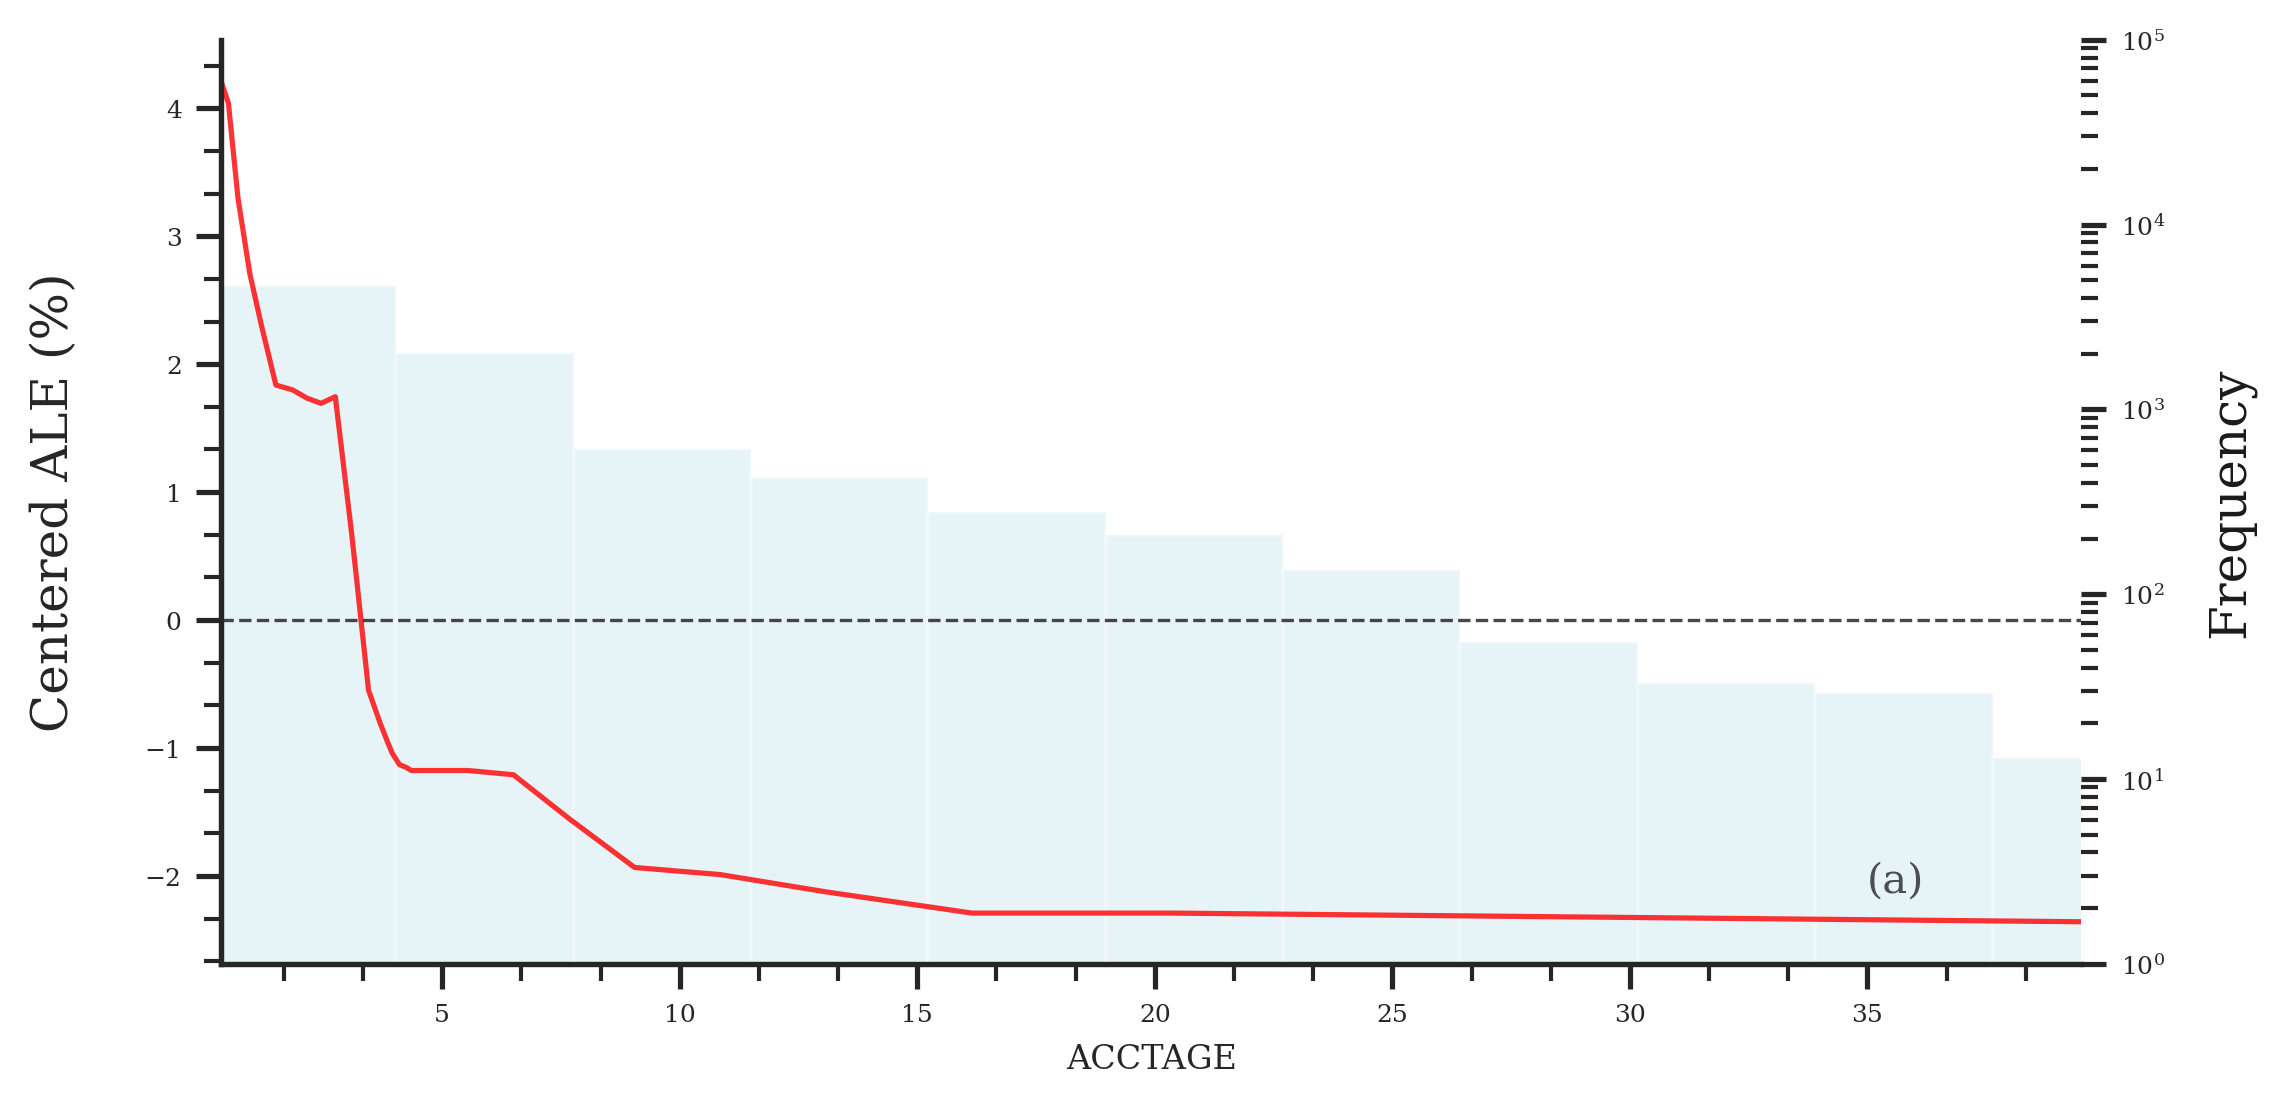

In [145]:

fig, axes = explainer.plot_ale(ale = ale, figsize=(8,4))

In [ ]:
train_subset = train.iloc[731]


In [149]:
# Extract the specific observation
train_subset = train.iloc[731]  # 0-indexed, observation 732 corresponds to index 731

# Prepare the data (reshape if needed for model compatibility)
X_customer = train_subset.drop('INS') 
y_customer = train_subset['INS']

# Predict the probability using your final model
predicted_prob = xgb_insRand.predict_proba([X_customer])[0, 1]  # Probability for class 1

# Print the results
print(f"Predicted Probability of Buying Insurance: {predicted_prob}")
print(f"Actual Outcome: {'Bought Insurance' if y_customer == 1 else 'Did Not Buy Insurance'}")

Predicted Probability of Buying Insurance: 0.5754142999649048
Actual Outcome: Bought Insurance


# Interpretation (Shapley Value)

In [154]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(xgb_insRand)
shap_values = explainer(x_train)

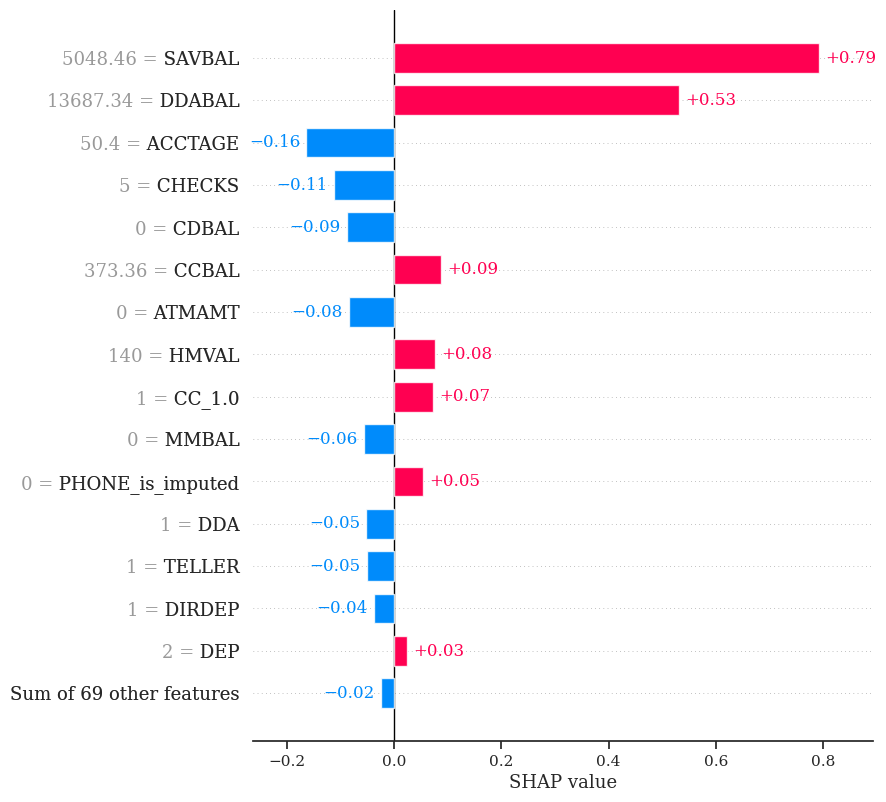

In [155]:
shap.plots.bar(shap_values[731], max_display = 16)